https://docs.opencv.org/4.x/d9/db7/tutorial_py_table_of_contents_calib3d.html

In [1]:
import os
import numpy as np
import cv2 as cv
import open3d as o3d
import laspy
import matplotlib.pyplot as plt
from pathlib import Path
from IPython import display
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks

import stereolib

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


@article{Zhou2018,
    author    = {Qian-Yi Zhou and Jaesik Park and Vladlen Koltun},
    title     = {{Open3D}: {A} Modern Library for {3D} Data Processing},
    journal   = {arXiv:1801.09847},
    year      = {2018},
}

In [2]:
# Path to the data directory
path_data = Path("./data")

In [3]:
# Load calibration matrices and vectors
calibration_path = path_data / Path("calibration") / Path("literal_v2")

# Calibration path for Literal v2    
calibration_filename = calibration_path / "Tricam.yaml"

# If this file exists, then load calibration from its content
if os.path.exists(calibration_filename):

    img_size_left, camera_mtx_left, dist_coefs_left, \
    img_size_right, camera_mtx_right, dist_coefs_right, \
    R_pair, T_pair, \
    serial_number, \
    calibration_datetime = stereolib.load_calibration_from_yaml(calibration_filename)

# Calibration has to be loaded from files previously generated with calibration.ipynb, from chessboard images
else:
    
    img_size_left, camera_mtx_left, dist_coefs_left, \
    img_size_right, camera_mtx_right, dist_coefs_right, \
    R_pair, T_pair = stereolib.load_calibration_from_numpy(calibration_path)
    

Serial number : 444302
Calibration date : 2024-11-06 10-04-59 

Left camera
Distortion model : PERSPECTIVE
Mean reprojection error : 0.2874501049518585 

Right camera
Distortion model : PERSPECTIVE
Mean reprojection error : 0.2875809967517853 

Stereo RGB pair
Mean reprojection error : 0.3562925457954407 



In [4]:
# Get the transformation matrices for rectification, from the intrinsic and distorsion parameters of each camera, 
# and rotation and translation matrices describing related positions of left and right cameras (coming from stereo calibration)
R_rect_left, R_rect_right, \
P_rect_left, P_rect_right, \
Q_rect_left, \
valid_pix_roi_1, valid_pix_roi_2  = cv.stereoRectify(camera_mtx_left,
                                                     dist_coefs_left,
                                                     camera_mtx_right,
                                                     dist_coefs_right,
                                                     img_size_left,
                                                     R_pair,
                                                     T_pair)

In [5]:
# Compute the maps (offset along rows and columns) to be applied to each pixel of each camera image (left and right), so that the left and right images
# are rectified (= lines of the two cameras are aligned)
# Left camera
map_left_1, map_left_2 = cv.initUndistortRectifyMap(camera_mtx_left,
                                                    dist_coefs_left,
                                                    R_rect_left,
                                                    P_rect_left,
                                                    img_size_left,
                                                    cv.CV_16SC2)

# Right camera
map_right_1, map_right_2 = cv.initUndistortRectifyMap(camera_mtx_right,
                                                      dist_coefs_right,
                                                      R_rect_right,
                                                      P_rect_right,
                                                      img_size_right,
                                                      cv.CV_16SC2)

In [6]:
# Distance between the two cameras, in mm. Expressed in mm, because at the calibration step, we specified the chessboard cell size in millimeters.
# This is simply computed considering the norm of the translation vector resulting of the stereo calibration pair.
baseline = np.linalg.norm(T_pair)

print(f"baseline = {baseline} mm")

baseline = 60.260691202703086 mm


In [7]:
# Focal length obtained after rectification, expressed in pixels 
focal_length = P_rect_left[0][0]

print(f"focal length = {focal_length} pixels")

focal length = 5057.804469493889 pixels


In [8]:
# Paths for Literal v2 images
path_rgb_images = path_data / Path("inputs")

# Elements composing the name of our images
name_base_camera = "Tricam1Camera"
left_id = 1
right_id = 2
plot_id = "556-A"
image_id = "1"
image_ext = "png"

# Name of the pair of images used
name_img_left = path_rgb_images / f"Plot{plot_id}_{name_base_camera}{left_id}_{image_id}.{image_ext}"
name_img_right = path_rgb_images / f"Plot{plot_id}_{name_base_camera}{right_id}_{image_id}.{image_ext}"

# Load left and right input images
img_left = stereolib.read_image(name_img_left)
img_right = stereolib.read_image(name_img_right)

In [9]:
# Paths for generated outputs
output_path = path_data / Path("outputs")
if os.path.isdir(output_path) is False:
            os.mkdir(output_path)

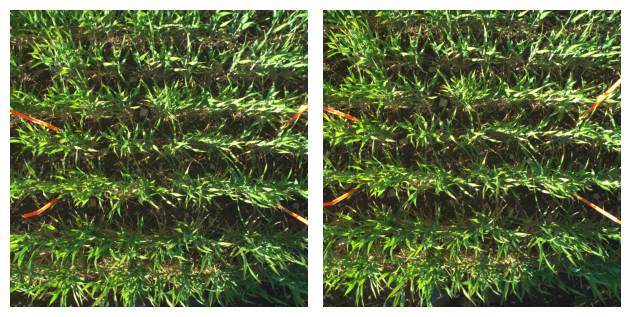

In [10]:
# Display input images
stereolib.display_images([name_img_left, name_img_right])

In [11]:
print(img_left.shape)

(3100, 3100, 3)


In [12]:
# Rectify both images, so that the lines of the left image are matching those in the right image.
rect_img_left = stereolib.rectify(img_left, map_left_1, map_left_2)
rect_img_right = stereolib.rectify(img_right, map_right_1, map_right_2)

In [13]:
# Save those images
name_rect_img_left = output_path / "rect_left_image.png"
name_rect_img_right = output_path / "rect_right_image.png"

stereolib.write_image(name_rect_img_left, rect_img_left)
stereolib.write_image(name_rect_img_right, rect_img_right)

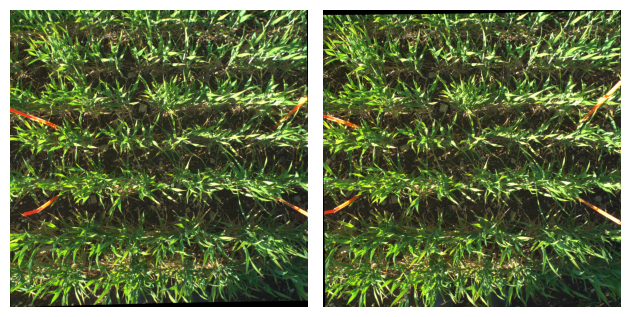

In [14]:
# Display rectified images
stereolib.display_images([name_rect_img_left, name_rect_img_right])

In the rectification operation, we chose to keep the original image size : you can observe that both left image and right images were slightly tilted, black pixels added at the bottom of the left, and at the top and left of the right image.

In [15]:
# Check the size of the recified image
print(rect_img_left.shape)

(3100, 3100, 3)


In [16]:
# Store height and width for further use
height, width = rect_img_left.shape[:2]

In [17]:
# Range of depth_image in which something is interesting (depending on one's application), in mm
range_operating_depth = [1200, 2800]

# Compute disparities corresponding to the given range
min_disparity_init = int(stereolib.compute_disparity_from_depth(baseline, focal_length, range_operating_depth[1]))

# Prohibits the '0' value (would lead to infinite depth_image as Z = (baseline * focal_length) / disparity)
min_disparity_init = max(min_disparity_init, 1)
min_disparity_init = int(min_disparity_init)
print(f"Min disparity boundary : {min_disparity_init}")

# Rounds to upper digit to ensure to matching the desired value
max_disparity_init = int(stereolib.compute_disparity_from_depth(baseline, focal_length, range_operating_depth[0])) + 1
print(f"Max disparity boundary : {max_disparity_init}")

# Compute the number of disparities (must be a multiple of 16)
num_disparities_init = stereolib.compute_number_of_disparities(min_disparity_init, max_disparity_init)
print(f"Number of disparities : {num_disparities_init}")

Min disparity boundary : 108
Max disparity boundary : 254
Number of disparities : 160


In [18]:
# Convert RGB images to grayscale for matching (not mandatory, may work with RGB images, but more demanding in terms of computation power and of quality of the input images)
rect_gray_img_left = cv.cvtColor(rect_img_left, cv.COLOR_BGR2GRAY)
rect_gray_img_right = cv.cvtColor(rect_img_right, cv.COLOR_BGR2GRAY)

In [19]:
# As images are rectified and both lines aligned, you may choose to downsample images along lines to reduce processing time and CPU charge
# (dependending on the resolution and objects size)
# Here for example we downsample by a 4 factor
factor_dwns = 4
rect_gray_img_left_dwns = np.copy(rect_gray_img_left[::factor_dwns, ...])
rect_gray_img_right_dwns = np.copy(rect_gray_img_right[::factor_dwns, ...])

In [20]:
# Parameters for filtering the disparity (/!\ : good rendering but may lead to approximations in distances). We don't activate filtering by default.
wls_activation = False
wls_sigma = 1.2

# Compute the disparity using for SGBM algorithm, with efficient parameters (for our application and from our experience)
ret, disparity_map, min_disparity, max_disparity = stereolib.stereo_processing(rect_gray_img_left_dwns,
                                                                               rect_gray_img_right_dwns,
                                                                               Q_rect_left,
                                                                               min_disparity_init,
                                                                               num_disparities_init,
                                                                               block_size=3,
                                                                               uniqueness_ratio=1,
                                                                               wls_activation=False,
                                                                               wls_sigma=1.2)

In [21]:
disparity_map.shape

(775, 3100)

In [22]:
disparity_map.dtype

dtype('float32')

In [23]:
min_disparity

108

In [24]:
np.min(disparity_map)

np.float32(107.0)

In [25]:
np.max(disparity_map)

np.float32(267.0)

In [26]:
# Compute the normalized total gradient to evaluate the matching quality : the principle is to compare and the left and the right-on-left mapped image obtained by applying disparity
# to each pixel.
# The ntg value is normalized in the [0, 1] interval ; a lower value means a good matching (generally around 0.2 / 0.3) and a higher one (above 0.5) a bad disparty map quality

@article{
    author    = {Chen, Shu-Jie & Shen, Hui-Liang & Li, Chunguang & Xin, John.},
    title     = {Normalized Total Gradient: A New Measure for Multispectral Image Registration.},
    journal   = {IEEE Transactions on Image Processing. PP. 1-1. 10.1109/TIP.2017.2776753.},
    year      = {2017},
}

In [27]:
ntg_value, difference_img, right_on_left = stereolib.normalized_total_gradient(rect_gray_img_left_dwns,
                                                                               disparity_map,
                                                                               rect_gray_img_right_dwns,
                                                                               min_disparity=min_disparity,
                                                                               max_disparity=max_disparity,
                                                                              )

In [28]:
ntg_value

np.float64(0.2987168279538642)

In [29]:
rect_gray_img_left_dwns.shape

(775, 3100)

In [30]:
# As (if) downsampling has been done, we have to resize and interpolate disparity map to original RGB images size
disparity_map = cv.resize(disparity_map, (width, height), cv.INTER_LINEAR_EXACT)
difference_img = cv.resize(difference_img, (width-max_disparity, height), cv.INTER_LINEAR_EXACT)
right_on_left = cv.resize(right_on_left, (width-max_disparity, height), cv.INTER_LINEAR_EXACT)


In [31]:
# Save those images
name_left_img = output_path / "ntg_left_image.png"
name_difference_img = output_path / "ntg_difference_image.png"
name_right_on_left_img = output_path / "ntg_right_on_left_image.png"

stereolib.write_image(name_left_img, rect_gray_img_left[:, max_disparity:])
stereolib.write_image(name_difference_img, difference_img)
stereolib.write_image(name_right_on_left_img, right_on_left)

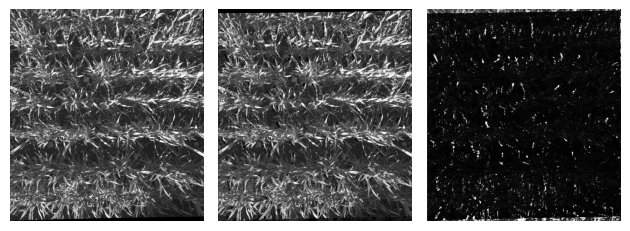

In [32]:
stereolib.display_images([name_left_img, name_right_on_left_img, name_difference_img])

In [33]:
rect_gray_img_left[:, max_disparity:].shape

(3100, 2833)

In [34]:
difference_img.shape

(3100, 2833)

In [35]:
right_on_left.shape

(3100, 2833)

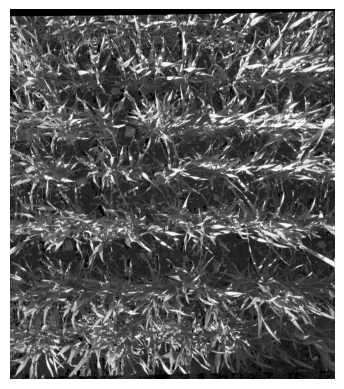

In [36]:
right_on_left[:, max_disparity:].shape

name_right_on_left_img = output_path / "ntg_right_on_left_image_short.png"

stereolib.write_image(name_right_on_left_img, right_on_left[:, min_disparity:])

stereolib.display_images([name_right_on_left_img])

In [37]:
disparity_image = stereolib.normalize_image(disparity_map)

In [38]:
np.min(disparity_image)

np.uint8(0)

In [39]:
np.max(disparity_image)

np.uint8(255)

In [40]:
disparity_image.shape

(3100, 3100)

In [41]:
disparity_image.dtype

dtype('uint8')

In [42]:
name_disparity_image = output_path / "disparity.png"

stereolib.write_image(name_disparity_image, disparity_image)

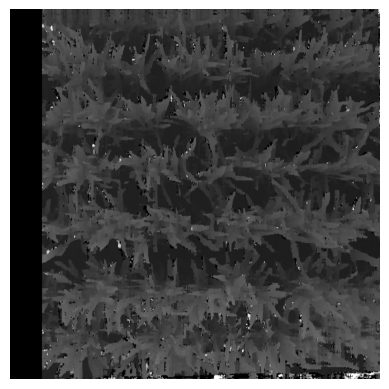

In [43]:
stereolib.display_images([name_disparity_image])

In [44]:
# Pixels for which no correspondence has been found are set to 'min_disparity-1' by the SGBM algorithm.
# We set these pixels to a negative value for easier discrimination (corresponding distances will be <0 too)

disparity_map[disparity_map == min_disparity - 1] = -1

In [45]:
# 3 channels image containing (X, Y, Z) coordinates in mm of each pixel (in the rectified left reference frame)
xyz_image = cv.reprojectImageTo3D(disparity_map, Q_rect_left, handleMissingValues=False)

In [46]:
# Crop the left stripe corresponding to max disparity (closest pixels not seen in the right image) in the 3 images that need to be coregistered
# Here you could choose not to work on the full image, but on a central cropped zone for example, or on a masked region (if you have a vegetation
# segmentation mask generated from the RGB left image for example ; in this case, be careful to correctly rectify your mask as was done with the
# left RGB image, so that it's correctly coregistered with your left RGB image)
rect_img_left = rect_img_left[:, max_disparity:]
disparity_map = disparity_map[:, max_disparity:]
xyz_image = xyz_image[:, max_disparity:]

In [47]:
depth_image = xyz_image[:,:,2]

In [48]:
depth_image

array([[-304786.8   ,    2101.0723,    2100.1675, ...,    1150.1389,
           1145.8151,    1145.5459],
       [-304786.8   ,    2101.0723,    2100.1675, ...,    1150.1389,
           1145.8151,    1145.5459],
       [-304786.8   ,    2101.0723,    2100.1675, ...,    1150.6816,
           1146.3538,    1145.5796],
       ...,
       [-304786.8   ,    2342.121 ,    2341.9805, ...,    1821.9171,
           1798.8156,    1792.2047],
       [-304786.8   ,    2342.2617,    2342.2617, ...,    1821.6619,
           1798.8156,    1792.2047],
       [-304786.8   ,    2342.2617,    2342.2617, ...,    1821.6619,
           1798.8156,    1792.2047]], shape=(3100, 2833), dtype=float32)

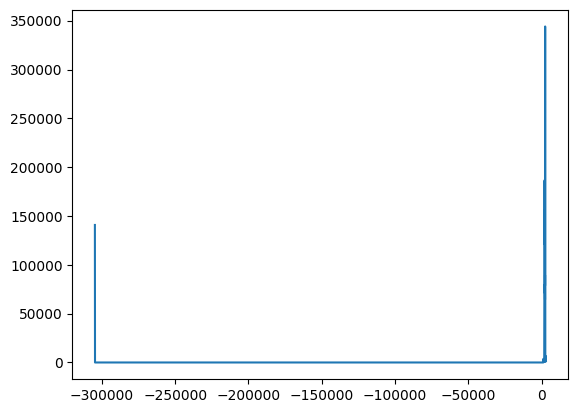

In [49]:
# We choose a step of 1 cm, which seems a be a correct compromise considering the acquisition system and context.
hist_range = int((np.max(depth_image) - np.min(depth_image)) / 10.)

# Compute the full depth_array histogram, without any filtering
depth_hist, depth_bins = np.histogram(depth_image, bins=hist_range)

# Plot the histogram
plt.plot(depth_bins[1:], depth_hist)

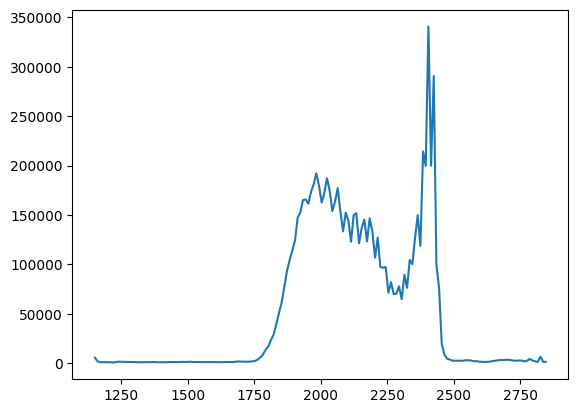

In [50]:
# Compute the depth_image histogram, without the Z negative erratic values (corresponding to pixels 
# for which no correspondence was found between left and right images)
depth_array = xyz_image[:,:,2][xyz_image[:,:,2] >= 0]

# We choose a step of 1 cm, which seems a be a correct compromise considering the acquisition system and context.
hist_range = int((np.max(depth_array) - np.min(depth_array)) / 10.)

depth_hist, depth_bins = np.histogram(depth_array, bins=hist_range)

# Plot the histogram
plt.plot(depth_bins[1:], depth_hist)

In [51]:
# To remove erratic reamining points, that may lead to bad soil distance estimation or plant height estimation, we will work with the 3D point cloud
# for an optimal filtering efficiency

# Copy the original (X,Y,Z) point cloud before downsampling
xyz_dwn_filtered = (np.copy(xyz_image).reshape(-1, 3).astype(np.float64))

# Keep only the valid Z values, i.e. positive ones (negative values dued to invalid disparity set to -1
valid_z_values, = np.where(xyz_dwn_filtered[:, 2] >= 0)

# Copy the original (R,G,B) point cloud before downsampling
rgb_left_dwn_filtered = (np.copy(rect_img_left).reshape(-1, 3).astype(np.float64))

If open3d package doesn't work, skip the following cells until you find @no_open3d

In [52]:
# Convert 3 channels (X,Y,Z) image into a Open3D point cloud 
pcd_xyz = o3d.geometry.PointCloud()
pcd_xyz.points = o3d.utility.Vector3dVector(xyz_dwn_filtered[valid_z_values])

# Convert 3 channels (R,G,B) image into a Open3D point cloud 
pcd_rgb = o3d.geometry.PointCloud()
pcd_rgb.points = o3d.utility.Vector3dVector(rgb_left_dwn_filtered[valid_z_values])

In [53]:
np.asarray(pcd_xyz.points)

array([[-581.80627441, -652.24609375, 2101.07226562],
       [-581.14050293, -651.96520996, 2100.16748047],
       [-580.72528076, -651.96520996, 2100.16748047],
       ...,
       [ 514.48168945,  550.65478516, 1821.66186523],
       [ 508.38497925,  543.7487793 , 1798.81555176],
       [ 506.87094116,  541.75042725, 1792.20471191]], shape=(8641484, 3))

In [54]:
# Downsampling factor for 
ptcld_downsampling_factor = 12

# Downsample original (X,Y,Z) point cloud for computation gain
pcd_xyz_dwn = pcd_xyz.uniform_down_sample(every_k_points=ptcld_downsampling_factor)

# Downsample corresponding (R,G,B) point cloud the same way
pcd_rgb_dwn = pcd_rgb.uniform_down_sample(every_k_points=ptcld_downsampling_factor)

In [55]:
# Convert the (X,Y,Z) point cloud and corresponding (R,G,B) point cloud into classical numpy arrays for filtering
xyz_dwn_filtered = np.array(pcd_xyz_dwn.points)
rgb_left_dwn_filtered = np.array(pcd_rgb_dwn.points)

In [57]:
np.asarray(xyz_dwn_filtered)

array([[-581.80627441, -652.24609375, 2101.07226562],
       [-424.07424927, -479.52587891, 1544.6907959 ],
       [-545.73693848, -622.47662354, 2005.1763916 ],
       ...,
       [ 610.26983643,  666.7131958 , 2205.60327148],
       [ 562.57818604,  609.38525391, 2015.95239258],
       [ 525.43902588,  564.35791016, 1866.9942627 ]], shape=(720124, 3))

In [58]:
# Nb of neighbours for filtering
nb_of_neighbors = 256
# Standard deviation for filtering
std_ratio = 0.05

# Filter X,Y,Z point cloud ; returns the filtered X,Y,Z point cloud and the vector containing the indices of remaining valid points 
# in the original point cloud
pcd_filtered, valid_pixels_array = pcd_xyz_dwn.remove_statistical_outlier(nb_neighbors=nb_of_neighbors, std_ratio=std_ratio)

In [59]:
# Keep only the valid points in the (X,Y,Z) and corresponding (R,G,B) point cloud
xyz_dwn_filtered = xyz_dwn_filtered[valid_pixels_array]
rgb_left_dwn_filtered = rgb_left_dwn_filtered[valid_pixels_array]

@no_open3d : If open3d doesn't work go on executing from the cell below.
Otherwise, skip the cell below and go to the next one

In [56]:
# Keep only the valid points in the (X,Y,Z) and corresponding (R,G,B) point cloud
xyz_dwn_filtered = xyz_dwn_filtered[valid_z_values]
rgb_left_dwn_filtered = rgb_left_dwn_filtered[valid_z_values]

In [60]:
# Name of the point cloud to be written
point_cloud_name = output_path / "pointcloud.laz"

# xyz_dwn_filtered = xyz_dwn_filtered[veg_mask_dwn_filtered>0]
# rgb_left_dwn_filtered = rgb_left_dwn_filtered[veg_mask_dwn_filtered>0]
stereolib.write_point_cloud(point_cloud_name, xyz_dwn_filtered, rgb_left_dwn_filtered)

In [61]:
# Get the third channel of the (X,Y,Z) filtered downsampled array (float32 values, in mm), corresponding to z values, i.e. depth_image to sensor
depth_array = xyz_dwn_filtered[:, 2]

# Convert the floating values into rounded integer values (mm precision is more than what is reasonably achievable).
depth_array = np.round(depth_array).astype(np.uint32)

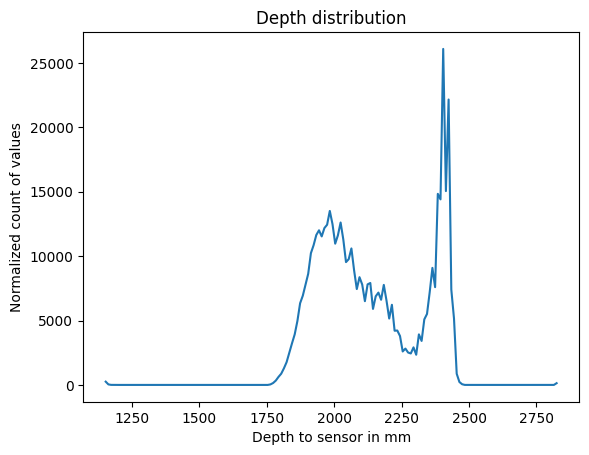

In [265]:
# Plot the depth_array histogram

# We choose a step of 1 cm, which seems a be a correct compromise considering the acquisition system and context.
hist_range = int((np.max(depth_array) - np.min(depth_array)) / 10.)

# Compute the depth_array histogram 
depth_hist, depth_bins = np.histogram(depth_array, bins=hist_range)
#depth_hist, depth_bins = np.histogram(depth_array, bins=10)

# We create a new figure
fig, ax = plt.subplots()

# Name of the horizontal axis
ax.set_xlabel('Depth to sensor in mm')
# Name of the vertical axis
ax.set_ylabel('Normalized count of values')

# Name of the plot
ax.set_title("Depth distribution")

# Plot the histogram
plt.plot(depth_bins[1:], depth_hist)

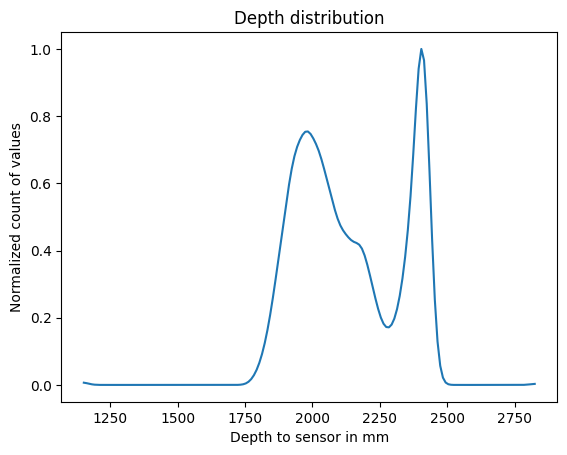

In [266]:
# Smooth the histogram to remove micropeaks
filtered_depth_hist = gaussian_filter1d(depth_hist, sigma=2)

# We normalize the histogram
norm_filtered_depth_hist = filtered_depth_hist / np.max(filtered_depth_hist)

# We create a new figure
fig, ax = plt.subplots()

# Name of the horizontal axis
ax.set_xlabel('Depth to sensor in mm')
# Name of the vertical axis
ax.set_ylabel('Normalized count of values')

# Name of the plot
ax.set_title("Depth distribution")

# We plot the filtered depth histogram
plt.plot(depth_bins[1:], norm_filtered_depth_hist)
#plt.savefig(output_path / Path('filtered_depth_hist.png'))

In [267]:
# We look for peaks into the depth histogram. In the favourable case (such this one) where soil is not so masked by the vegetation, 
# we can assume that the last peak corresponds to the ground level.
# The function returns peaks indices in the array, if any was found
peaks, _ = find_peaks(norm_filtered_depth_hist, height=0.1)

In [268]:
# We display the depths corresponding to the peaks indices
depth_bins[peaks+1]

array([1983.5 , 2404.25])

In [269]:
# We assign the depth of the last peak to our ground estimated value
ground_depth = 0
if len(peaks) > 0:
    ground_depth = depth_bins[peaks[-1]+1]

In [270]:
ground_depth = np.round(ground_depth).astype(np.uint32)

In [271]:
ground_depth

np.uint32(2404)

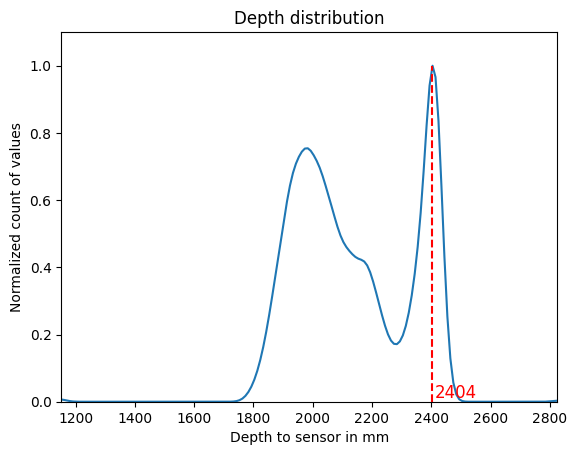

In [272]:
# We create a new figure
fig, ax = plt.subplots()

# We plot once again the filtered depth histogram
plt.plot(depth_bins[1:], norm_filtered_depth_hist)

# Margins and limits of the plot
ax.margins(x=0, y=0)
ax.set_ylim(0, 1.1)

# We plot the vertical line corresponding to the ground estimated depth
plt.vlines(ground_depth, 0,1, linestyles='dashed', color='r')

# We annotate the line with appropriate value
ax.annotate(f'{ground_depth}', xy=(ground_depth, 0), xytext=(2, 0),
            textcoords='offset points',
            ha='left', va='bottom',
            fontsize=12, color='red')

# Name of the horizontal axis
ax.set_xlabel('Depth to sensor in mm')
# Name of the vertical axis
ax.set_ylabel('Normalized count of values')

# Name of the plot
ax.set_title("Depth distribution")

plt.savefig(output_path / Path('filtered_depth_hist.png'))

In [273]:
# Heigths may then be simply estimated by calculating the difference between the ground distance and the distances to objects
height_array = ground_depth - depth_array

In [274]:
height_array = height_array[height_array > 0]
height_array = height_array[height_array < ground_depth]

In [275]:
# We choose a step of 1 cm, which seems a be a correct compromise considering the acquisition system and context.
hist_range = int((np.max(height_array) - np.min(height_array)) / 10.)

# Compute the height histogram
height_hist, height_bins = np.histogram(height_array, bins=hist_range)

# Smooth the histogram to remove micropeaks, just as we did with depth
filtered_height_hist = gaussian_filter1d(height_hist, sigma=2)

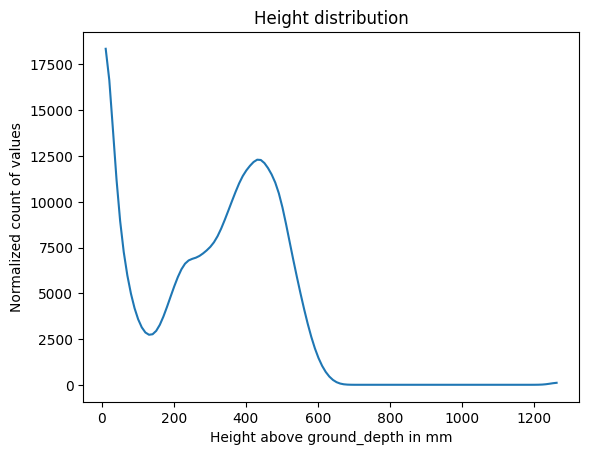

In [276]:
# We create a new figure
fig, ax = plt.subplots()

# Name of the horizontal axis
ax.set_xlabel('Height above ground_depth in mm')
# Name of the vertical axis
ax.set_ylabel('Normalized count of values')

# Name of the plot
ax.set_title("Height distribution")

# We plot the histogram
plt.plot(height_bins[1:], filtered_height_hist)
plt.savefig(output_path / Path('filtered_height_hist.png'))

In [277]:
# We compute the cumulative height distribution
cumulative_height_distribution = np.cumsum(filtered_height_hist)

# We normalize it so that valus are int the interval [0,1]
cumulative_height_distribution = cumulative_height_distribution / np.max(cumulative_height_distribution)

# We define the desired percentile of the distribution, that will lead to a consistent height value (for wheat), 
# based on many comparisons with manual height measurements.
percentile = 0.98

# We keep only height values that are above this percentile
mean_height_array, = np.where(cumulative_height_distribution >= percentile)

In [278]:
mean_height_array

array([ 56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,
        69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,
        82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,
        95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107,
       108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120,
       121, 122, 123, 124, 125])

In [279]:
# We retrieve the first value and define it as the mean height
mean_height = height_bins[mean_height_array[0]+1]

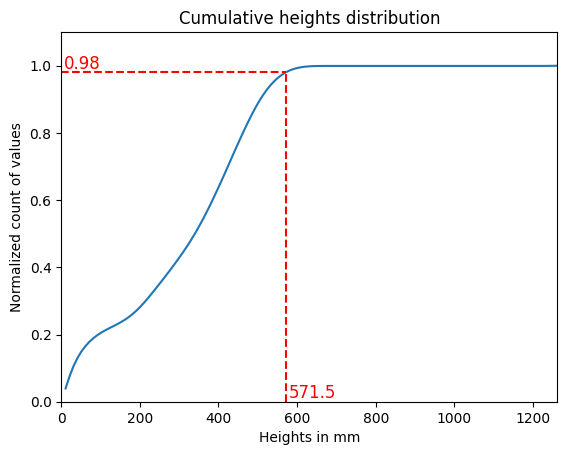

In [280]:
# We create a new figure
fig, ax = plt.subplots()

# We plot the cumulative heights histogram
plt.plot(height_bins[1:], cumulative_height_distribution)

# We plot the horizontal line corresponding to the desired percentile (98%) of the the height cumulative distribution count 
plt.hlines(0.98, 0, mean_height, linestyles='dashed', color='r')

# We annotate the line with appropriate value
ax.annotate(f'0.98', xy=(0, 0.98), xytext=(2, 0),
            textcoords='offset points',
            ha='left', va='bottom',
            fontsize=12, color='red')

# We plot the vertical line where the desired percentile (98%) is reached in the cumulative distribution
plt.vlines(mean_height, 0, 0.98, linestyles='dashed', color='r')

# We annotate the line with appropriate value
ax.annotate(f'{mean_height:.1f}', xy=(mean_height, 0), xytext=(2, 0),
            textcoords='offset points',
            ha='left', va='bottom',
            fontsize=12, color='red')

# Margins and limits of the plot
ax.margins(x=0, y=0)
ax.set_ylim(0, 1.1)

# Name of the horizontal axis
ax.set_xlabel('Heights in mm')
# Name of the vertical axis
ax.set_ylabel('Normalized count of values')

# Name of the plot
ax.set_title("Cumulative heights distribution")

plt.savefig(output_path / Path('cumulative_height_distribution.png'))

In [258]:
mean_height

np.float64(571.452380952381)

In [259]:
np.min(height_array)

np.uint32(1)

In [260]:
np.max(height_array)

np.uint32(1262)

In [261]:
# We can go back to the non-filtered depth image to have a representation of the heights of objects in the image, 
# Distances are in mm in depth_image ; we divide those values by 10, so that we get the heights with a cm precision in a 8 bits image
# (values between 0 and 255 cm)
height_image = ((ground_depth - depth_image) / 10.)

In [262]:
height_image[height_image < 0] = 0
height_image[height_image > 255] = 0 

height_image = height_image.astype(np.uint8)

In [263]:
depth_image

array([[-304786.8   ,    2101.0723,    2100.1675, ...,    1150.1389,
           1145.8151,    1145.5459],
       [-304786.8   ,    2101.0723,    2100.1675, ...,    1150.1389,
           1145.8151,    1145.5459],
       [-304786.8   ,    2101.0723,    2100.1675, ...,    1150.6816,
           1146.3538,    1145.5796],
       ...,
       [-304786.8   ,    2342.121 ,    2341.9805, ...,    1821.9171,
           1798.8156,    1792.2047],
       [-304786.8   ,    2342.2617,    2342.2617, ...,    1821.6619,
           1798.8156,    1792.2047],
       [-304786.8   ,    2342.2617,    2342.2617, ...,    1821.6619,
           1798.8156,    1792.2047]], shape=(3100, 2833), dtype=float32)

In [264]:
height_image

array([[  0,  30,  30, ..., 125, 125, 125],
       [  0,  30,  30, ..., 125, 125, 125],
       [  0,  30,  30, ..., 125, 125, 125],
       ...,
       [  0,   6,   6, ...,  58,  60,  61],
       [  0,   6,   6, ...,  58,  60,  61],
       [  0,   6,   6, ...,  58,  60,  61]],
      shape=(3100, 2833), dtype=uint8)

In [239]:
name_height_image = output_path / "height.png"

stereolib.write_image(name_height_image, height_image)

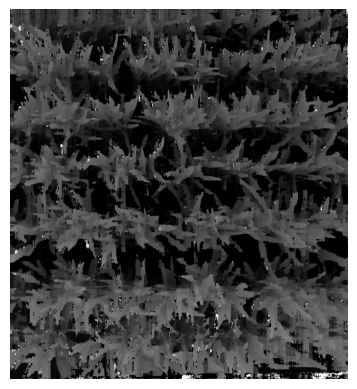

In [240]:
stereolib.display_images([name_height_image])